## Natural Language Processing with TensorFlow

In [1]:
# get the helper function
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
# Import series of helper functions for the notebook
#from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

### Download a text dataset

In [3]:
# Download data (same as from Kaggle)
#!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

In [4]:
# # unzip the dwnloaded file
# import zipfile

# zip_ref = zipfile.ZipFile(("nlp_getting_started.zip"))
# zip_ref.extractall()
# zip_ref.close()

### Visualizing the dataset

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [9]:
train_df.count(), test_df.count()

(id          7613
 keyword     7552
 location    5080
 text        7613
 target      7613
 dtype: int64,
 id          3263
 keyword     3237
 location    2158
 text        3263
 dtype: int64)

In [10]:
# shuffle the data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
train_df_shuffled["target"].count()

7613

In [12]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [13]:
train_df.columns.values

array(['id', 'keyword', 'location', 'text', 'target'], dtype=object)

In [14]:
# visualize the random samples
for row in train_df[["text", "target"]].sample(n=5).itertuples():
    _, text_value, target_value = row
    print(f"Target: {target_value}", "[disaster]" if int(target_value) > 0 else "[not disaster]")
    print(f"Test: {text_value}")
    print("-----\n")

Target: 0 [not disaster]
Test: I crashed my car into a parked car the other day... #modestmouseremix #truestory
-----

Target: 0 [not disaster]
Test: @harveymaine AAAA ok lemme move to another roomr so no one hears my gay ass screams
-----

Target: 1 [disaster]
Test: 'There was a small earthquake in LA but don't worry Emily Rossum is fine' #difficultpeople is great
-----

Target: 1 [disaster]
Test: APC Chieftain Tasks Dickson On N15b Floods Donation To Bayelsa http://t.co/LqGOe7psXp
-----

Target: 1 [disaster]
Test: @JasonPope2 @JohnFugelsang again I didn't say it was. I was referring to the main 2 buildings. 7 was hit by rubble
-----



In [15]:
### Spliting the data into train and validation
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                           train_df_shuffled["target"].to_numpy(),
                                                                           test_size=0.1,
                                                                           random_state=42)

In [16]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [17]:
# View the 5 training sentences and their labels
train_sentences[:5], train_labels[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object),
 array([0, 0, 1, 0, 0]))

### Converting text into numbers

#### Text vectorization (tokenization)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

default_text_vectorization = TextVectorization(max_tokens=None,
                                               standardize="lower_and_strip_punctuation", 
                                               split="whitespace",
                                               ngrams=None,
                                               output_mode="int",
                                               output_sequence_length=None)

2022-01-29 20:26:26.543244: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-01-29 20:26:26.543278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: bourne
2022-01-29 20:26:26.543289: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: bourne
2022-01-29 20:26:26.543357: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-01-29 20:26:26.543414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-01-29 20:26:26.543425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-01-29 20:26:26.543668: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operat

In [19]:
total_train_words = sum(len(words.split()) for words in train_sentences)
print(total_train_words)
avg_words_per_sentence = total_train_words / len(train_sentences)
round(avg_words_per_sentence)

102087


15

In [20]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [21]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Create sample sentence and tokenize it
sample_sentence = "covid 19 cases are increasing again !!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 1338, 1702,   22,    1,  282,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
import random
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Find out how your fund was used for Typhoon Haiyan in the Philippines. See @DevPeace Haiyan Relief Funds Report http://t.co/JwxrX1LsqO      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 653,   36,   62,   33, 2984,   23,  493,   10,  494, 3794,    4,
           2, 1186,   99,    1]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


#### Creating an Embedding using an Embedding Layer

In [25]:
from tensorflow.keras.layers import Embedding
import tensorflow as tf

tf.random.set_seed(42)

embedding = Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_length,
                      name="embedding_1")

In [26]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@SnowyWolf5 @TheGreenParty Besides would you rather shut down a whole nuclear reactor for maintenance or a wind turbine at a time?      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02739256,  0.03522961,  0.0478737 , ..., -0.01285902,
          0.04138485, -0.00105117],
        [-0.0304304 ,  0.00092275,  0.00728374, ..., -0.00593842,
         -0.03516513,  0.00155967],
        [-0.02039832, -0.04198135,  0.01101891, ..., -0.03038355,
          0.03587143,  0.0358495 ],
        ...,
        [-0.03508195,  0.01448471,  0.00513798, ...,  0.04485155,
          0.03976364, -0.03543619],
        [ 0.00846229,  0.00479295,  0.02089298, ...,  0.0283854 ,
          0.02527254, -0.01181388],
        [-0.04538491,  0.02194316,  0.02299335, ...,  0.03143641,
         -0.00354359,  0.04591903]]], dtype=float32)>

#### More specifically, we'll be building the following:

   * Model 0: Naive Bayes (baseline)
   * Model 1: Feed-forward neural network (dense model)
   * Model 2: LSTM model
   * Model 3: GRU model
   * Model 4: Bidirectional-LSTM model
   * Model 5: 1D Convolutional Neural Network
   * Model 6: TensorFlow Hub Pretrained Feature Extractor
   * Model 7: Same as model 6 with 10% of training data
    
##### **Model 0** is the simplest to acquire a **baseline** which we'll expect each other of the other deeper models to beat.

### **Model 0: Getting a baseline**

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (**term frequency-inverse document frequency**) formula to convert our words to numbers and then model them with the [Multinomial Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). This was chosen via referring to the Scikit-Learn machine learning map.

 This was chosen via referring to the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
], verbose=True)

# Fit the pipeline to the training data
fitted_steps = model_0.fit(train_sentences, train_labels)

[Pipeline] ............. (step 1 of 2) Processing tfidf, total=   0.1s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.0s


In [28]:
fitted_steps.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())],
 'verbose': True,
 'tfidf': TfidfVectorizer(),
 'clf': MultinomialNB(),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'clf__alpha': 1.0,
 'clf__class_prior': None,
 'clf__fit_prior': True}

In [29]:
baseline_score = model_0.score(val_sentences, val_labels)

In [30]:
baseline_score * 100

79.26509186351706

In [31]:
# make prediction from baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

#### Creating an evaluation function for our model experiments

In [32]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [33]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### **Model 1: A Dense model**

In [34]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [35]:
# Build model with the Functional API
from tensorflow.keras.layers import Dense, Input, GlobalAvgPool1D
from tensorflow.keras import Model

inputs = Input(shape=(1,), name="input_layer", dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = GlobalAvgPool1D()(x)
outputs = Dense(1, activation="sigmoid", name="model_1_ouptut")(x)

model_1 = Model(inputs, outputs, name="model_1_dense")

In [36]:
# compile the model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
model_1.compile(loss=binary_crossentropy, 
                optimizer= Adam(),
                metrics=["accuracy"])

In [37]:
# model summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 model_1_ouptut (Dense)      (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [38]:
# fit the model
model_1_history = model_1.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220129-202631
Epoch 1/5
215/215 [==============================] - 3s 13ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [39]:
# evaluate the model
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 1ms/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [40]:
# make predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:5]

array([[0.40488204],
       [0.7443312 ],
       [0.99789494],
       [0.10889998],
       [0.11143532]], dtype=float32)

In [41]:
# Turn prediction probabilities into single-dimension tensor of floats
print(model_1_pred_probs.shape)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

(762, 1)


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [42]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

### **Model 2: LSTM**
LSTM = Long Short Term Memory

In [43]:
# Create LSTM model
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras import Model

inputs = Input(shape=(1,), dtype=tf.string, name="lstm_inputs")
x = text_vectorizer(inputs)
x = embedding(x)
x = LSTM(64, activation="tanh")(x)
outputs = Dense(1, activation="sigmoid", name="model_2_lstm_output")(x)

model_2 = Model(inputs,outputs, name="model_2_lstm")

In [44]:
# get the summary
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_inputs (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 model_2_lstm_output (Dense)  (None, 1)                65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [45]:
# compile the model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

model_2.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [46]:
# fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_2_lstm")])

Saving TensorBoard log files to: model_logs/model_2_lstm/20220129-202646
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.2208 - accuracy: 0.9210 - val_loss: 0.5403 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1614 - accuracy: 0.9415 - val_loss: 0.6062 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1274 - accuracy: 0.9521 - val_loss: 0.7357 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1073 - accuracy: 0.9596 - val_loss: 0.8344 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0849 - accuracy: 0.9656 - val_loss: 0.9325 - val_accuracy: 0.7795


In [47]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:5]

array([[7.6124668e-03],
       [6.8414563e-01],
       [9.9959624e-01],
       [3.4396797e-02],
       [2.2518635e-04]], dtype=float32)

In [48]:
# Round out pred probs and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [85]:
# Calculate our model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                   y_pred=model_2_preds)
model_2_results

{'accuracy': 77.95275590551181,
 'precision': 0.7819506047193071,
 'recall': 0.7795275590551181,
 'f1': 0.7772730329412364}

### **Model 3: GRU**
GRU = Gated recurrent unit (one of the most popular and useful recurrent layer types)

In [50]:
# building the RNN model using GRU layer
import tensorflow as tf
from tensorflow.keras.layers import Dense, GRU, Input
from tensorflow.keras import Model

inputs = Input(shape=(1, ), dtype=tf.string, name="model_3_input")
x = text_vectorizer(inputs)
x = embedding(x)
x = GRU(64, activation="tanh")(x)
outputs = Dense(1, activation="sigmoid", name="model_3_output")(x)

model_3 = Model(inputs, outputs, name="model_3_gru")

In [51]:
# compile the model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

model_3.compile(loss=binary_crossentropy,
                optimizer=Adam(),
                metrics=["accuracy"])

In [52]:
# model summary
model_3.summary()

Model: "model_3_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3_input (InputLayer)  [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 model_3_output (Dense)      (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [53]:
# fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name="model_3_gru")])

Saving TensorBoard log files to: model_logs/model_3_gru/20220129-202707
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.1560 - accuracy: 0.9385 - val_loss: 0.6572 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0861 - accuracy: 0.9686 - val_loss: 0.7952 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0722 - accuracy: 0.9720 - val_loss: 1.0512 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0677 - accuracy: 0.9745 - val_loss: 1.0347 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0556 - accuracy: 0.9766 - val_loss: 1.0512 - val_accuracy: 0.7690


In [54]:
# Make predictions with the trained model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10], model_3_pred_probs.shape

(array([[6.2815785e-02],
        [7.8835511e-01],
        [9.9976885e-01],
        [9.5390022e-02],
        [1.3333559e-04],
        [9.9963820e-01],
        [8.2681853e-01],
        [9.9993140e-01],
        [9.9983907e-01],
        [9.4554180e-01]], dtype=float32),
 (762, 1))

In [55]:
# Convert model 3 pred probs into labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [56]:
# Calculate results for model 3
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.9028871391076,
 'precision': 0.7689137548517897,
 'recall': 0.7690288713910761,
 'f1': 0.768063295978387}

### **Model 4: Bidirectional RNN model**

In [57]:
# Build a bidirectional RNN in TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Bidirectional, LSTM
from tensorflow.keras import Model

inputs = Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = Bidirectional(LSTM(64))(x)
outputs = Dense(1, activation="sigmoid")(x)
model_4 = Model(inputs, outputs, name="model_4_bidirectional")

In [58]:
# model_4 summary()
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [59]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit model
history_model_4 = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220129-202728
Epoch 1/5
215/215 [==============================] - 7s 22ms/step - loss: 0.1085 - accuracy: 0.9717 - val_loss: 0.9050 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0597 - accuracy: 0.9764 - val_loss: 1.0827 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0494 - accuracy: 0.9774 - val_loss: 1.2966 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0434 - accuracy: 0.9800 - val_loss: 1.3755 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0363 - accuracy: 0.9825 - val_loss: 1.7084 - val_accuracy: 0.7598


In [60]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10], model_4_pred_probs.shape

(array([[5.32448292e-04],
        [7.30594754e-01],
        [9.99986708e-01],
        [1.21692926e-01],
        [6.80609082e-06],
        [9.99942541e-01],
        [9.90393937e-01],
        [9.99995828e-01],
        [9.99990940e-01],
        [9.99740720e-01]], dtype=float32),
 (762, 1))

In [61]:
# Convert pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [62]:
# Calculate model 4 results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.98425196850394,
 'precision': 0.7599947657549518,
 'recall': 0.7598425196850394,
 'f1': 0.7584680708642795}

### **Model 5: Conv1D**

In [63]:
# Create 1-dimensional CNN to model sequences
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPool1D
from tensorflow.keras import Model

inputs = Input(shape=(1,), dtype=tf.string, name="model_5_input")
x = text_vectorizer(inputs)
x = embedding(x)
x = Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = GlobalMaxPool1D()(x)
outputs = Dense(1, activation="sigmoid", name="model_5_output")(x)

model_5 = Model(inputs, outputs, name="model_5_conv1d")

In [64]:
# model 5 summary
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_5_input (InputLayer)  [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 model_5_output (Dense)      (None, 1)              

In [65]:
# Compile model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              batch_size=32,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20220129-202753
Epoch 1/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1377 - accuracy: 0.9585 - val_loss: 0.8317 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0757 - accuracy: 0.9714 - val_loss: 1.0009 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0624 - accuracy: 0.9768 - val_loss: 1.0789 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0548 - accuracy: 0.9785 - val_loss: 1.1674 - val_accuracy: 0.7546
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0504 - accuracy: 0.9778 - val_loss: 1.2061 - val_accuracy: 0.7612


In [66]:
# Make predictions with our 1D CNN
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5], model_5_pred_probs.shape

(array([[8.3698869e-02],
        [6.6586018e-01],
        [9.9995434e-01],
        [9.6137673e-02],
        [2.8227561e-08]], dtype=float32),
 (762, 1))

In [67]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [68]:
# Calculate results for model 5
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.11548556430446,
 'precision': 0.7622953452640989,
 'recall': 0.7611548556430446,
 'f1': 0.7591215732608759}

### **Model 6: TensorFlow Hub Pretrained Sentence Encoder**

Using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/

In [69]:
# get the USE from tensorflow hub
# url = "https://tfhub.dev/google/universal-sentence-encoder/4"
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [70]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [71]:
# create the model using Sequential API
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model_6 = Sequential([
    sentence_encoder_layer,
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid", name="model_6_output")
], name="model_6_use")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [72]:
# model summmary
model_6.summary()

Model: "model_6_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 model_6_output (Dense)      (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [73]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220129-202815
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.5039 - accuracy: 0.7872 - val_loss: 0.4485 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.4146 - accuracy: 0.8140 - val_loss: 0.4370 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3999 - accuracy: 0.8228 - val_loss: 0.4321 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3923 - accuracy: 0.8259 - val_loss: 0.4269 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3857 - accuracy: 0.8307 - val_loss: 0.4284 - val_accuracy: 0.8163


In [74]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.16333416],
       [0.7379844 ],
       [0.9887543 ],
       [0.21095747],
       [0.7271445 ],
       [0.66852057],
       [0.97907925],
       [0.97519076],
       [0.9222555 ],
       [0.0947502 ]], dtype=float32)

In [75]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [76]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8190827553840537,
 'recall': 0.8162729658792651,
 'f1': 0.8146067773916925}

### **Model 7: TF Hub Pretrained USE but with 10% of training data**

In [77]:
# dataset split 
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [78]:
# create the model using Sequential API
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model_7 = Sequential([
  sentence_encoder_layer,
  Dense(64, activation="relu"),
  Dense(1, activation="sigmoid", name="output_layer")                               
], name="model_7_USE")

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [79]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20220129-202825
Epoch 1/5
22/22 [==============================] - 1s 27ms/step - loss: 0.6714 - accuracy: 0.6818 - val_loss: 0.6490 - val_accuracy: 0.7126
Epoch 2/5
22/22 [==============================] - 0s 14ms/step - loss: 0.6007 - accuracy: 0.8088 - val_loss: 0.5911 - val_accuracy: 0.7690
Epoch 3/5
22/22 [==============================] - 0s 14ms/step - loss: 0.5228 - accuracy: 0.8234 - val_loss: 0.5330 - val_accuracy: 0.7756
Epoch 4/5
22/22 [==============================] - 0s 14ms/step - loss: 0.4600 - accuracy: 0.8234 - val_loss: 0.5013 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 0s 13ms/step - loss: 0.4181 - accuracy: 0.8394 - val_loss: 0.4857 - val_accuracy: 0.7795


In [80]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.1814042 ],
       [0.5688577 ],
       [0.9215586 ],
       [0.36991227],
       [0.5568163 ],
       [0.6910775 ],
       [0.8953402 ],
       [0.8298417 ],
       [0.85683227],
       [0.1506845 ]], dtype=float32)

In [81]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [82]:
# Evalaute model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'precision': 0.7802422774076316,
 'recall': 0.7795275590551181,
 'f1': 0.7781078501550943}

### **Comparing the peformance of each of our models**

In [86]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.740157,0.791492,0.787402,0.784697
2_lstm,77.952756,0.781951,0.779528,0.777273
3_gru,76.902887,0.768914,0.769029,0.768063
4_bidirectional,75.984252,0.759995,0.759843,0.758468
5_conv1d,76.115486,0.762295,0.761155,0.759122
6_tf_hub_use_encoder,81.627297,0.819083,0.816273,0.814607
7_tf_hub_use_encoder_10_percent,77.952756,0.780242,0.779528,0.778108


In [87]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
# all_model_results

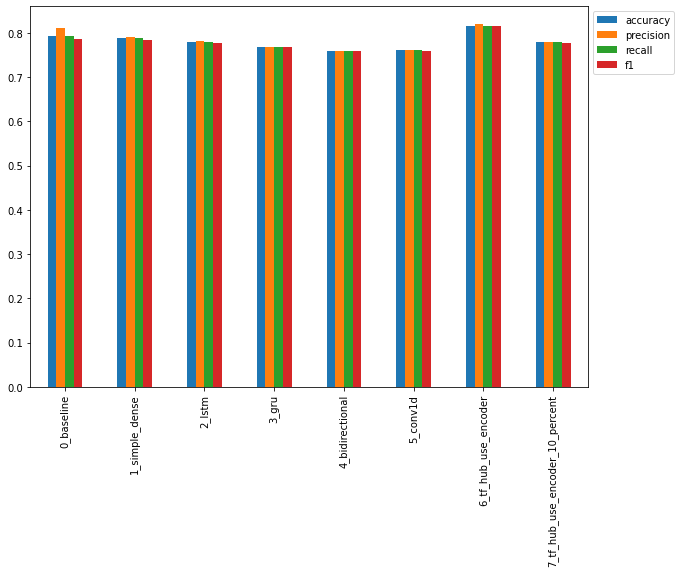

In [88]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

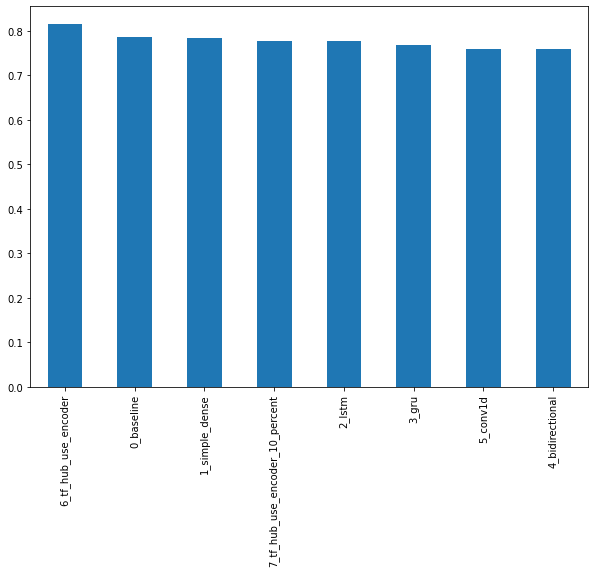

In [89]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

### **Saving and loading a trained model**

In [95]:
model_6.save("saved_models/h5/model_6.h5")

In [96]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("saved_models/h5/model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [97]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 21ms/step - loss: 0.4284 - accuracy: 0.8163


[0.42841193079948425, 0.8162729740142822]

In [100]:
# Save TF Hub Sentence Ecnoder model to SavedModel format (default)
model_6.save("saved_models/tf/model_6_SavedModel_format")

INFO:tensorflow:Assets written to: saved_models/tf/model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: saved_models/tf/model_6_SavedModel_format/assets


In [102]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("saved_models/tf/model_6_SavedModel_format")

In [103]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 51ms/step - loss: 0.4284 - accuracy: 0.8163


[0.42841193079948425, 0.8162729740142822]

### **Finding the most wrong examples**

Using **Model 6** to create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities


In [111]:
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.163334
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.737984
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988754
3,@camilacabello97 Internally and externally scr...,1,0.0,0.210957
4,Radiation emergency #preparedness starts with ...,1,1.0,0.727144


In [112]:
val_df.shape

(762, 4)

In [113]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914415
628,@noah_anyname That's where the concentration c...,0,1.0,0.856423
759,FedEx will no longer transport bioterror patho...,0,1.0,0.854090
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.844770
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.844662
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.821227
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.792817
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.791750
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.774536
144,The Sound of Arson,0,1.0,0.769984


In [114]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
233,I get to smoke my shit in peace,1,0.0,0.042373
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.041573
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.040565
38,Why are you deluged with low self-image? Take ...,1,0.0,0.037162
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.030338


In [116]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:5].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.914415180683136
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8564230799674988
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8540899753570557
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8447698354721069
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1.0, Prob: 0.8446618914604187
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----



In [117]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-5:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.04237303137779236
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0.0, Prob: 0.04157322645187378
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.040564775466918945
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

----

Target: 1, Pred: 0.0, Prob: 0.037161678075790405
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

----

Target: 1, Pred: 0.0, Prob: 0.03033807873725891
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

----



### **Making predictions on the test dataset**

In [118]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

Pred: 0, Prob: 0.12716808915138245
Text:
New post: Cowboys believe Lance Dunbar&amp;#039;s ankle injury not serious http://t.co/XMCRedFXAt

-----

Pred: 0, Prob: 0.05218258500099182
Text:
WHAT A DISASTER FOR SECRET  #TI5

-----

Pred: 0, Prob: 0.08022814989089966
Text:
Ltd Toy Stamp &amp; Vintage Tonka TFD No 5 Pressed Steel Pumper Fire Truck  - Full read by eBay http://t.co/hTvyEnXCBS http://t.co/xSvPzxYRe3

-----

Pred: 0, Prob: 0.05345901846885681
Text:
Don't let your #writing suffer a fatality! Learn how to seek and destroy bad writing--weekly on Live Write Thrive: http://t.co/VVuL9eGPe8

-----

Pred: 0, Prob: 0.11754807829856873
Text:
@f_body95 never riding in the gaymaro ... Would damage my reputation

-----

Pred: 0, Prob: 0.43238091468811035
Text:
#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/QDwRjmmk89

-----

Pred: 1, Prob: 0.9429948925971985
Text:
Rescuers are searching for hundreds of migrants in the Mediterranean after a boat carrying